In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv("../data/adausdt.csv")
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,Ignore
0,2021-11-01 08:00:00,1.965,2.019,1.911,1.949,144061135.4,1635811199999,2.824457e+08,443944,71078236.0,1.394258e+08,0
1,2021-11-02 08:00:00,1.949,1.996,1.933,1.971,124263204.0,1635897599999,2.446304e+08,382592,64339347.3,1.267002e+08,0
2,2021-11-03 08:00:00,1.971,2.144,1.950,2.063,335561983.7,1635983999999,6.936646e+08,1237122,167743048.3,3.467647e+08,0
3,2021-11-04 08:00:00,2.063,2.103,1.933,1.983,174549100.4,1636070399999,3.509825e+08,586577,80789835.4,1.624612e+08,0
4,2021-11-05 08:00:00,1.983,2.017,1.959,1.982,108180863.7,1636156799999,2.150281e+08,346939,51873631.3,1.030921e+08,0


The trading strategy is simple:
- Long the stock if the shorter SMA > longer SMA
- Short  the stock if the shorter SMA < longer SMA

In [3]:
short_sma = 7
long_sma = 14

In [4]:
df['SMA1'] = df['Close'].rolling(short_sma).mean()
df['SMA2'] = df['Close'].rolling(long_sma).mean()
# drop the rows with NaN entries
df.dropna(inplace=True)
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,Ignore,SMA1,SMA2
239,2022-06-28 08:00:00,0.4855,0.4975,0.4671,0.4694,163559982.8,1656460799999,7.894841e+07,186022,78703385.9,3.800271e+07,0,0.529443,1.069858
240,2022-06-29 08:00:00,0.4693,0.4772,0.4588,0.4662,166130162.2,1656547199999,7.777351e+07,171783,79642286.4,3.729005e+07,0,0.525990,1.063679
241,2022-06-30 08:00:00,0.4662,0.4677,0.4352,0.4599,212174584.9,1656633599999,9.507568e+07,216004,106495608.1,4.772010e+07,0,0.520427,1.057383
242,2022-07-01 08:00:00,0.4599,0.4750,0.4427,0.4487,182788187.1,1656719999999,8.308157e+07,182713,90547200.6,4.116893e+07,0,0.516997,1.050657
243,2022-07-02 08:00:00,0.4487,0.4617,0.4408,0.4559,109165380.7,1656806399999,4.919145e+07,103433,54511257.6,2.456075e+07,0,0.512623,1.044294


In [5]:
df['Position'] = np.where(df['SMA1'] > df['SMA2'], 1, -1)

In [6]:
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,Ignore,SMA1,SMA2,Position
239,2022-06-28 08:00:00,0.4855,0.4975,0.4671,0.4694,163559982.8,1656460799999,7.894841e+07,186022,78703385.9,3.800271e+07,0,0.529443,1.069858,-1
240,2022-06-29 08:00:00,0.4693,0.4772,0.4588,0.4662,166130162.2,1656547199999,7.777351e+07,171783,79642286.4,3.729005e+07,0,0.525990,1.063679,-1
241,2022-06-30 08:00:00,0.4662,0.4677,0.4352,0.4599,212174584.9,1656633599999,9.507568e+07,216004,106495608.1,4.772010e+07,0,0.520427,1.057383,-1
242,2022-07-01 08:00:00,0.4599,0.4750,0.4427,0.4487,182788187.1,1656719999999,8.308157e+07,182713,90547200.6,4.116893e+07,0,0.516997,1.050657,-1
243,2022-07-02 08:00:00,0.4487,0.4617,0.4408,0.4559,109165380.7,1656806399999,4.919145e+07,103433,54511257.6,2.456075e+07,0,0.512623,1.044294,-1


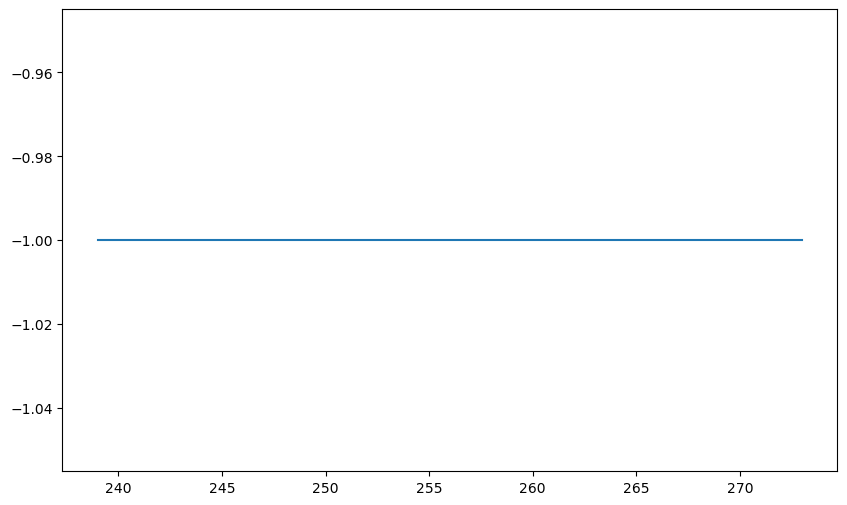

In [7]:
ax = df['Position'].plot(figsize=(10,6))

## Machine Learning Approach: Classification

Another strategy is that we compute the log returns for each consecutive timestamps.

In [8]:
df = pd.read_csv("../data/adausdt.csv")
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,Ignore
0,2021-11-01 08:00:00,1.965,2.019,1.911,1.949,144061135.4,1635811199999,2.824457e+08,443944,71078236.0,1.394258e+08,0
1,2021-11-02 08:00:00,1.949,1.996,1.933,1.971,124263204.0,1635897599999,2.446304e+08,382592,64339347.3,1.267002e+08,0
2,2021-11-03 08:00:00,1.971,2.144,1.950,2.063,335561983.7,1635983999999,6.936646e+08,1237122,167743048.3,3.467647e+08,0
3,2021-11-04 08:00:00,2.063,2.103,1.933,1.983,174549100.4,1636070399999,3.509825e+08,586577,80789835.4,1.624612e+08,0
4,2021-11-05 08:00:00,1.983,2.017,1.959,1.982,108180863.7,1636156799999,2.150281e+08,346939,51873631.3,1.030921e+08,0


In [9]:
df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)
df['direction'] = np.sign(df['returns']).astype(int)

In [10]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, 3):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)
    print('The following columns have been added: \n')
    print(cols)

In [11]:
create_lags(df)

The following columns have been added: 

['lag_1', 'lag_2']


In [12]:
df.dropna(inplace=True)

In [13]:
split = int(len(df) * 0.80)

In [14]:
train = df.iloc[:split].copy()
train.shape

(216, 16)

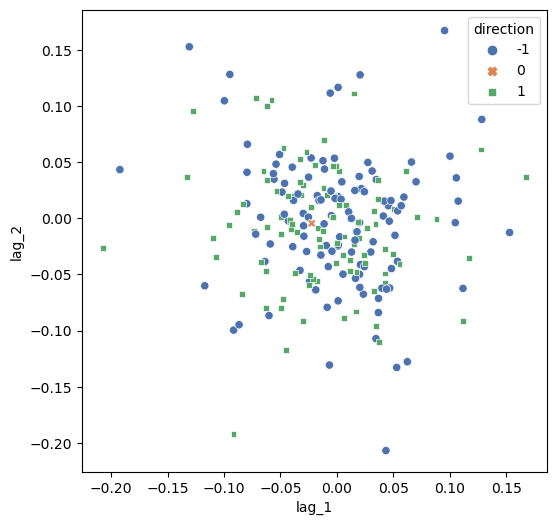

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(6,6))
fig = sns.scatterplot(data=train, x="lag_1", y="lag_2", hue="direction", style="direction", palette="deep")

For our logistic regression model, 

$$
z = \overrightarrow{w} \cdot \overrightarrow{x} + b
$$

From the raw features data, we transformed into a polynomial with terms $x_1$ and $x_2$, 
which represents `lag_1` and `lag_2` respectively.

$$
y = w_1 x_1 + w_2 x_2 + w_3 x_1^2 + \cdots + w_n x_1^7 x_2^8
$$

In [16]:
import sys
sys.path.append('../')

from utils import *

X_mapped = map_feature(train.lag_1, train.lag_2)
X_mapped

array([[ 4.56202059e-02,  1.12246076e-02,  2.08120319e-03, ...,
         4.16237781e-15,  1.02413080e-15,  2.51981904e-16],
       [-3.95503846e-02,  4.56202059e-02,  1.56423292e-03, ...,
         1.41008362e-11, -1.62649001e-11,  1.87610841e-11],
       [-5.04413630e-04, -3.95503846e-02,  2.54433110e-07, ...,
         9.73818206e-16,  7.63557570e-14,  5.98695073e-12],
       ...,
       [ 1.15402967e-02, -4.72583793e-02,  1.33178449e-04, ...,
         1.48356608e-12, -6.07531421e-12,  2.48788667e-11],
       [ 1.58744191e-03,  1.15402967e-02,  2.51997181e-06, ...,
         5.95247443e-18,  4.32729670e-17,  3.14583405e-16],
       [ 7.09179355e-02,  1.58744191e-03,  5.02935357e-03, ...,
         8.04820842e-20,  1.80152781e-21,  4.03257755e-23]])

In [17]:
# Initialize fitting parameters
np.random.seed(42)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ to 1 (you can try varying this)
lambda_ = 0.01;                                          
# Some gradient descent settings
iterations = 10000
alpha = 0.01

y_train = train.direction.to_numpy()

w,b, J_history,_ = gradient_descent(z_scaler(X_mapped), y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     1.63   
Iteration 1000: Cost    -0.33   
Iteration 2000: Cost    -0.71   
Iteration 3000: Cost    -1.02   
Iteration 4000: Cost    -1.32   
Iteration 5000: Cost    -1.61   
Iteration 6000: Cost    -1.90   
Iteration 7000: Cost    -2.18   
Iteration 8000: Cost    -2.46   
Iteration 9000: Cost    -2.74   
Iteration 9999: Cost    -3.02   


once computed, the fitting parameters are

In [18]:
w

array([-2.66610257e+00, -1.26076391e+00, -6.80987660e+00, -4.68830000e-02,
       -7.76267389e+00, -2.23448260e-03, -7.56078827e-01,  7.51622635e-02,
       -9.99238896e-02, -5.75913632e-02, -6.19148101e-01,  2.73163534e-01,
        2.10756292e-01, -5.75261421e-01, -4.54182659e-01, -4.74994138e-01,
       -3.48144432e-01, -1.34167326e-01, -2.29783347e-01, -3.63632410e-01,
       -4.54114484e-02, -5.13918957e-01, -3.62627859e-01, -2.87578991e-01,
       -1.98766007e-01,  1.32413452e-01, -4.58112407e-01, -1.39323886e-01,
       -6.19269318e-02, -6.07704602e-01, -4.67427574e-02, -4.83699658e-01,
       -5.89305603e-01,  2.94362224e-01,  3.11525192e-01,  1.54079833e-01,
       -3.49568650e-01, -5.56552428e-01,  3.00239515e-02, -2.14069158e-01,
       -5.32165125e-01, -1.59047894e-01, -6.19769218e-01,  2.54989200e-01])

/home/pehcy/projects/binoculars/src/notebook/../utils.py:5: RuntimeWarning: overflow encountered in exp
  g = 1 / (1 + np.exp(np.negative(z)))


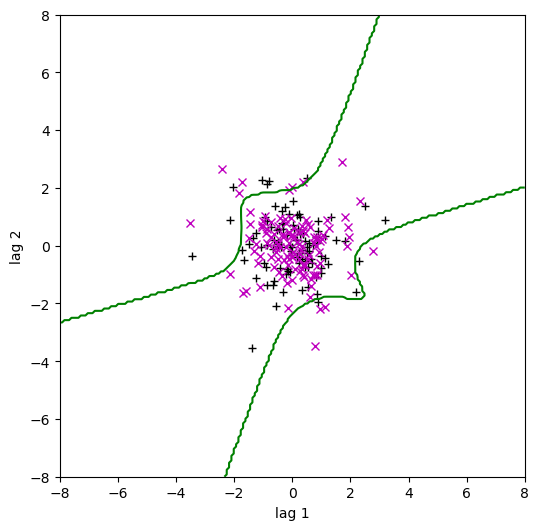

In [19]:
is_positive = train[train['direction'] > 0]
is_negative = train[train['direction'] <= 0]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(z_scaler(is_positive['lag_1']), z_scaler(is_positive['lag_2']), 'k+')
ax.plot(z_scaler(is_negative['lag_1']), z_scaler(is_negative['lag_2']), 'mx')
plt.xlabel('lag 1')
plt.ylabel('lag 2')
plot_decision_boundary(ax, w, b, z_scaler(X_mapped), y_train)